# Imports

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import datetime

# Variables and Utils

In [3]:
import sharedVariables
from sharedVariables import *  

def to_human_readable(size):
    power = 1000
    n = 0
    mem = {0 : 'B', 1: 'KB', 2: 'MB', 3: 'GB', 4: 'TB'}
    while size > power:
        size /=  power
        n += 1
    return "{0:.2f} {1}".format(size, mem[n])

todaystring = datetime.datetime.today().strftime('%Y%m%d')
outdir = f"data/{todaystring}"
if not os.path.exists(outdir):
    os.mkdir(outdir)

sync_timings = list(pd.to_datetime(['2021-07-21T01:40:12.495194358Z', '2021-07-21T01:36:06.906168096Z',
       '2021-07-21T01:32:20.769974404Z', '2021-07-21T01:28:46.650947007Z',
       '2021-07-21T01:25:24.874192553Z', '2021-07-21T01:18:48.444698374Z',
       '2021-07-21T01:14:52.702846072Z', '2021-07-21T01:11:17.139797585Z',
       '2021-07-21T01:07:51.620853144Z']))
base_timings = list(pd.to_datetime(['2021-07-21T01:37:44.391046353Z', '2021-07-21T01:34:09.592287642Z',
       '2021-07-21T01:30:33.719478397Z', '2021-07-21T01:27:08.165382341Z',
       '2021-07-21T01:23:47.975327731Z', '2021-07-21T01:19:58.095786286Z',
       '2021-07-21T01:16:22.724758295Z', '2021-07-21T01:12:47.119141410Z',
       '2021-07-21T01:09:06.449328442Z']))

# Data Preparation

In [4]:
def filterDataForLocalTraffic(df): 
    df = df[df["jsonPayload.connection.src_ip"].str.contains(r'^10\.')]
    df = df[df["jsonPayload.connection.dest_ip"].str.contains(r'^10\.')]
    return df

# df_sync = loadData('data/20210721/experiment-syncmesh-with-latency-3.log')
# df_base = loadData('data/20210721/experiment-baseline-with-latency-3.log')
df_sync = loadDataCSV(f'{outdir}/experiment-syncmesh-with-latency-3.csv')
df_base = loadDataCSV(f'{outdir}/experiment-baseline-with-latency-3.csv')

# df_sync.info()

orig_df = df_sync

df_sync = filterDataForLocalTraffic(df_sync)
df_base = filterDataForLocalTraffic(df_base)

df_base.to_csv(f"test.csv")
# TODO: Filter Entries for port specific traffic



nodes = list(dict.fromkeys(df_base["jsonPayload.connection.dest_ip"].unique().tolist() + df_base["jsonPayload.connection.src_ip"].unique().tolist()))
nodes = [node for node in nodes if node not in [ip_client, ip_server, ip_orchestrator]]
# print(nodes)

# Print Table
# df[["jsonPayload.connection.src_ip", "jsonPayload.connection.src_port", "jsonPayload.connection.dest_ip", "jsonPayload.bytes_sent", "jsonPayload.rtt_msec"]].unique()
# df_sync.index



FileNotFoundError: [Errno 2] File data/20210801/experiment-syncmesh-with-latency-3.csv does not exist: 'data/20210801/experiment-syncmesh-with-latency-3.csv'

In [4]:

def calcSubset(df, ports = [8080,27017]):
    # df = df[df['jsonPayload.connection.dest_port'].isin(ports)]
    # df = df[df['jsonPayload.connection.src_port'].isin(ports)]


    fromClient = df[df['jsonPayload.connection.src_ip']==ip_client]
    toServer = df[df['jsonPayload.connection.dest_ip']==ip_server]


    fromClientDataset = {}
    toServerDataset = {}
    betweenNodesDataset = {}
    for node in nodes: 
        fromClientDataset[node] = fromClient[fromClient['jsonPayload.connection.dest_ip']==node]

    nodeCombinations = list(itertools.combinations(nodes, r=2))
    for combination in nodeCombinations: 
        # Use both src_ip and dest_ip as they are not request related
        fromNode = df[df['jsonPayload.connection.src_ip'].isin(combination)]
        # fromAnyNode = df[df["jsonPayload.connection.src_ip"].isin(nodes)]
        betweenNodesDataset["between " + combination[0] + " and " + combination[1]] = fromNode[fromNode['jsonPayload.connection.dest_ip'].isin(combination)]

    for node in nodes: 
        toServerDataset[node] = toServer[toServer['jsonPayload.connection.src_ip']==node]
    
    return fromClientDataset, toServerDataset, betweenNodesDataset

fromClientDataset, toServerDataset, betweenNodesDataset = calcSubset(df_base, [27017])

# print(nodeCombinations)
# toServer.head()
# toServerDataset["10.2.0.12"].head()
# betweenNodesDataset['between 10.1.0.11 and 10.3.0.13'].info()
# fromClientDataset

# Results

## General

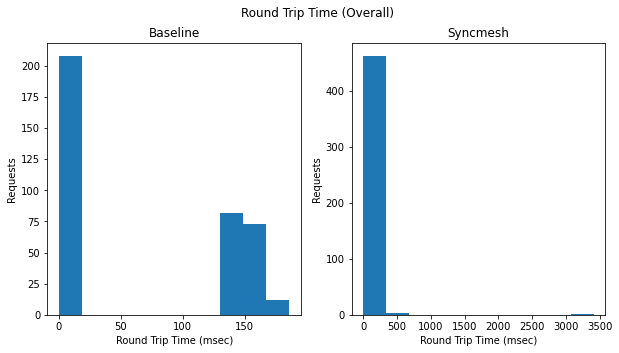

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Round Trip Time (Overall)')
base_remove0 = df_base[df_base['jsonPayload.bytes_sent']!=0]
sync_remove0 = df_sync[df_sync['jsonPayload.bytes_sent']!=0]
ax1.hist(base_remove0['jsonPayload.rtt_msec'])
ax1.set_title("Baseline")
ax1.set_ylabel("Requests")
ax1.set_xlabel("Round Trip Time (msec)")
ax2.hist(sync_remove0['jsonPayload.rtt_msec'])
ax2.set_title("Syncmesh")
ax2.set_ylabel("Requests")
ax2.set_xlabel("Round Trip Time (msec)")
fig.savefig("out/roundtrip_overall.png")

## Case: Baseline (Central Mongo)

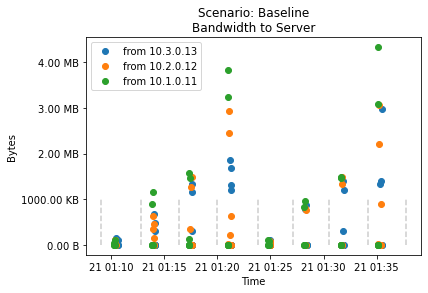

In [6]:
fig, ax = plt.subplots()
# ax.set_ylim(0,500)
for key in toServerDataset: 
    ax.plot(toServerDataset[key].index, toServerDataset[key]["jsonPayload.bytes_sent"], label="from " + key, marker='o', linestyle='None')
# set title and legend
ax.set_title('Scenario: Baseline\nBandwidth to Server')
ax.set_ylabel("Bytes")
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.set_xlabel("Time")
ax.legend()
for timing in base_timings: 
    ax.vlines(timing, 0, 999999, linestyle='--', alpha=0.2)
fig.savefig("out/bandwidth_to_server.png")
plt.show()

## Case: Syncmesh

In [7]:
fromClientDataset, toServerDataset, betweenNodesDataset = calcSubset(df_sync, [8080])

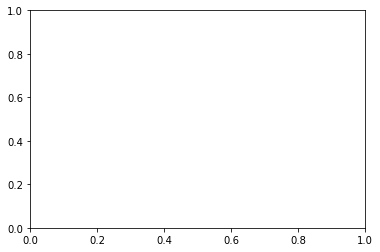

In [8]:
fig, ax = plt.subplots()
# plot histogram
binwidth = 10

# ax.hist(fromClientTo4['jsonPayload.bytes_sent'], bins=range(min(fromClientTo4['jsonPayload.bytes_sent']), max(fromClientTo4['jsonPayload.bytes_sent']) + binwidth, binwidth))
# ax.set_title("Package Size Histogram for Client to 4")

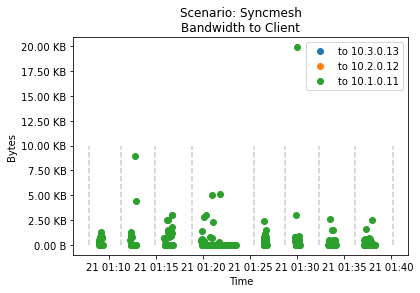

In [23]:
fig, ax = plt.subplots()
# ax.set_ylim(0,500)
for key in fromClientDataset: 
    ax.plot(fromClientDataset[key].index, fromClientDataset[key]["jsonPayload.bytes_sent"], label="to " + key, marker='o', linestyle='None')
# set title and legend
ax.set_title('Scenario: Syncmesh\nBandwidth to Client')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend()
for timing in list(pd.to_datetime(sync_timings)): 
    ax.vlines(timing, 0, 9999, linestyle='--', alpha=0.2)
# fig.savefig("out/bandwidth_from_client.png")
plt.show()

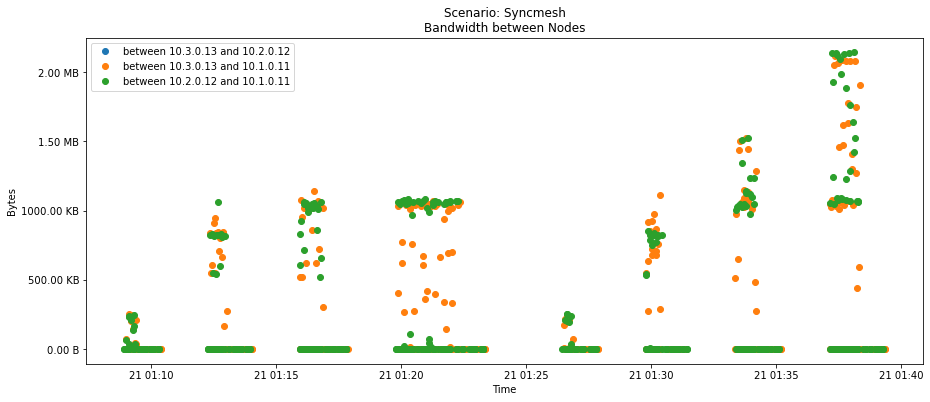

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# ax.set_ylim(0,500)
for key in betweenNodesDataset: 
    ax.plot(betweenNodesDataset[key].index, betweenNodesDataset[key]["jsonPayload.bytes_sent"], label=key, marker='o', linestyle='None')
# set title and legend
ax.set_title('Scenario: Syncmesh\nBandwidth between Nodes')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend(loc='upper left')

fig.savefig("out/bandwidth_between_nodes.png")
plt.show()

# Comparison

[Timestamp('2021-07-21 01:37:44.391046353+0000', tz='UTC'), Timestamp('2021-07-21 01:34:09.592287642+0000', tz='UTC')]
[Timestamp('2021-07-21 01:34:09.592287642+0000', tz='UTC'), Timestamp('2021-07-21 01:30:33.719478397+0000', tz='UTC')]
[Timestamp('2021-07-21 01:30:33.719478397+0000', tz='UTC'), Timestamp('2021-07-21 01:27:08.165382341+0000', tz='UTC')]
[Timestamp('2021-07-21 01:27:08.165382341+0000', tz='UTC'), Timestamp('2021-07-21 01:23:47.975327731+0000', tz='UTC')]
[Timestamp('2021-07-21 01:23:47.975327731+0000', tz='UTC'), Timestamp('2021-07-21 01:19:58.095786286+0000', tz='UTC')]
[Timestamp('2021-07-21 01:19:58.095786286+0000', tz='UTC'), Timestamp('2021-07-21 01:16:22.724758295+0000', tz='UTC')]
[Timestamp('2021-07-21 01:16:22.724758295+0000', tz='UTC'), Timestamp('2021-07-21 01:12:47.119141410+0000', tz='UTC')]
[Timestamp('2021-07-21 01:12:47.119141410+0000', tz='UTC'), Timestamp('2021-07-21 01:09:06.449328442+0000', tz='UTC')]
{0: {'baseAggregateBytes': 19541385, 'baseAggreg

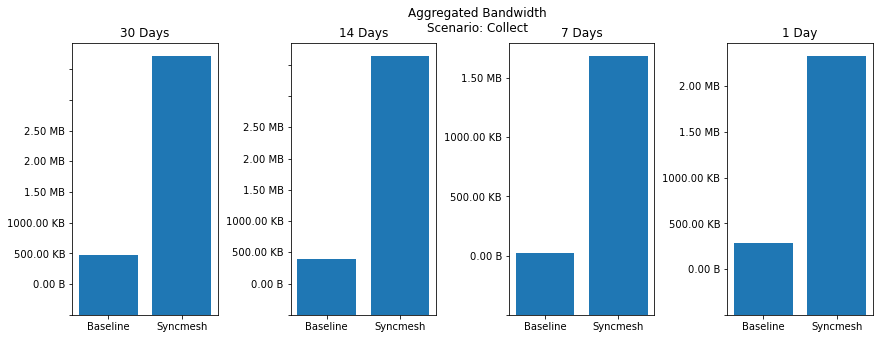

In [30]:
experiments = {}

# Sliding window:
n = 2
base_windows = [base_timings[i:i+n] for i in range(len(base_timings)-n+1)]
sync_windows = [sync_timings[i:i+n] for i in range(len(sync_timings)-n+1)]

i = 0
for base_window, sync_window in zip(base_windows, sync_windows):
    # experiment = {}
    print(base_window)
    df_base_window = df_base.loc[str(base_window[0]):str(base_window[1])]
    df_sync_window = df_sync.loc[str(sync_window[0]):str(sync_window[1])]
    # print(df_base_window.info())
    experiments[i] = {}
    experiments[i]["baseAggregateBytes"] =  df_base_window["jsonPayload.bytes_sent"].sum()
    experiments[i]["baseAggregateRTT"] = df_base_window["jsonPayload.rtt_msec"].mean()
    experiments[i]["syncAggregateBytes"] = df_sync_window["jsonPayload.bytes_sent"].sum()
    experiments[i]["syncAggregateRTT"] = df_sync_window["jsonPayload.rtt_msec"].mean()
    i += 1

# timedfbaseline.info()
print(experiments)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15,5))
cases = ['Baseline', 'Syncmesh']
values1 = [experiments[0]["baseAggregateBytes"], experiments[0]["syncAggregateBytes"]]
values2 = [experiments[1]["baseAggregateBytes"], experiments[1]["syncAggregateBytes"]]
values3 = [experiments[2]["baseAggregateBytes"], experiments[2]["syncAggregateBytes"]]
values4 = [experiments[3]["baseAggregateBytes"], experiments[3]["syncAggregateBytes"]]
fig.suptitle('Aggregated Bandwidth\nScenario: Collect')
ax1.bar(cases,values1)
ax1.set_title('30 Days')
ax1.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax2.bar(cases,values2)
ax2.set_title('14 Days')
ax2.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax3.bar(cases,values3)
ax3.set_title('7 Days')
ax3.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
box = ax3.get_position()
ax3.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax4.bar(cases,values4)
ax4.set_title('1 Day')
ax4.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
box = ax4.get_position()
ax4.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax.set_ylabel("Bytes")
# ax.set_xlabel("Time")
fig.savefig("out/bandwith_aggregate_comparison_collect.png")
plt.show()

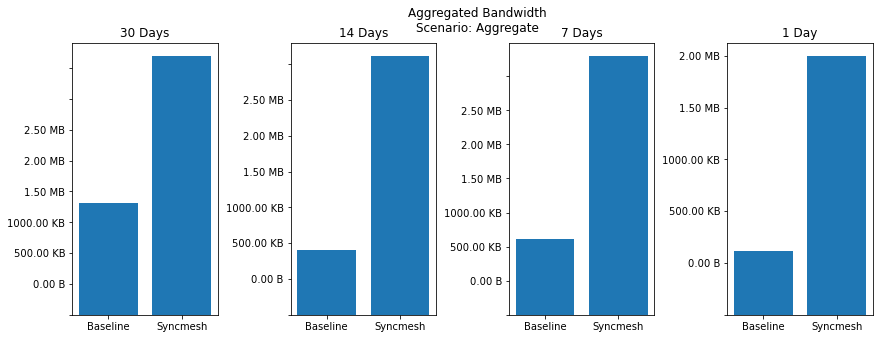

In [31]:
## Bandwidth Aggregated
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15,5))
cases = ['Baseline', 'Syncmesh']
values1 = [experiments[4]["baseAggregateBytes"], experiments[4]["syncAggregateBytes"]]
values2 = [experiments[5]["baseAggregateBytes"], experiments[5]["syncAggregateBytes"]]
values3 = [experiments[6]["baseAggregateBytes"], experiments[6]["syncAggregateBytes"]]
values4 = [experiments[7]["baseAggregateBytes"], experiments[7]["syncAggregateBytes"]]
fig.suptitle('Aggregated Bandwidth\nScenario: Aggregate')
ax1.bar(cases,values1)
ax1.set_title('30 Days')
ax1.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax2.bar(cases,values2)
ax2.set_title('14 Days')
ax2.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax3.bar(cases,values3)
ax3.set_title('7 Days')
ax3.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
box = ax3.get_position()
ax3.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax4.bar(cases,values4)
ax4.set_title('1 Day')
ax4.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
box = ax4.get_position()
ax4.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax.set_ylabel("Bytes")
# ax.set_xlabel("Time")
fig.savefig("out/bandwith_aggregated_comparison_aggregate.png")
plt.show()

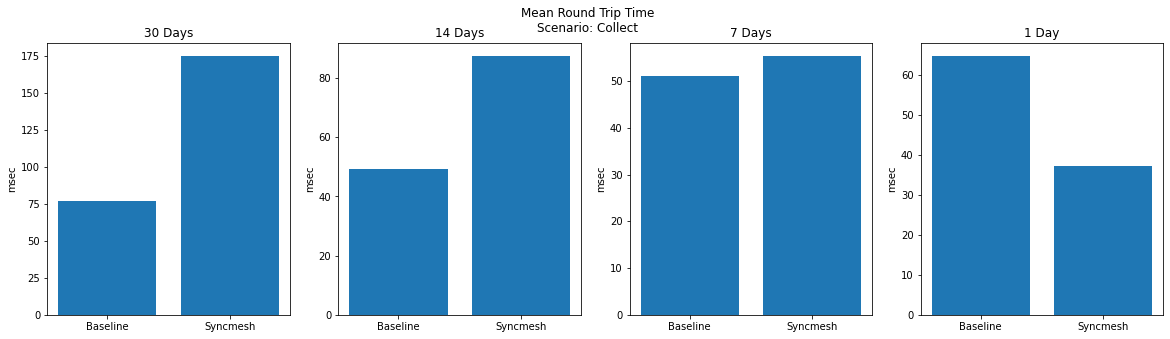

In [32]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,5))
cases = ['Baseline', 'Syncmesh']
values1 = [experiments[0]["baseAggregateRTT"], experiments[0]["syncAggregateRTT"]]
values2 = [experiments[1]["baseAggregateRTT"], experiments[1]["syncAggregateRTT"]]
values3 = [experiments[2]["baseAggregateRTT"], experiments[2]["syncAggregateRTT"]]
values4 = [experiments[3]["baseAggregateRTT"], experiments[3]["syncAggregateRTT"]]
fig.suptitle('Mean Round Trip Time\nScenario: Collect')
ax1.bar(cases,values1)
ax1.set_title('30 Days')
ax1.set_ylabel("msec")
ax2.bar(cases,values2)
ax2.set_title('14 Days')
ax2.set_ylabel("msec")
ax3.bar(cases,values3)
ax3.set_title('7 Days')
ax3.set_ylabel("msec")
ax4.bar(cases,values4)
ax4.set_title('1 Day')
ax4.set_ylabel("msec")
# ax.set_ylabel("Bytes")
# ax.set_xlabel("Time")
fig.savefig("out/rtt_mean_comparison_collect.png")
plt.show()

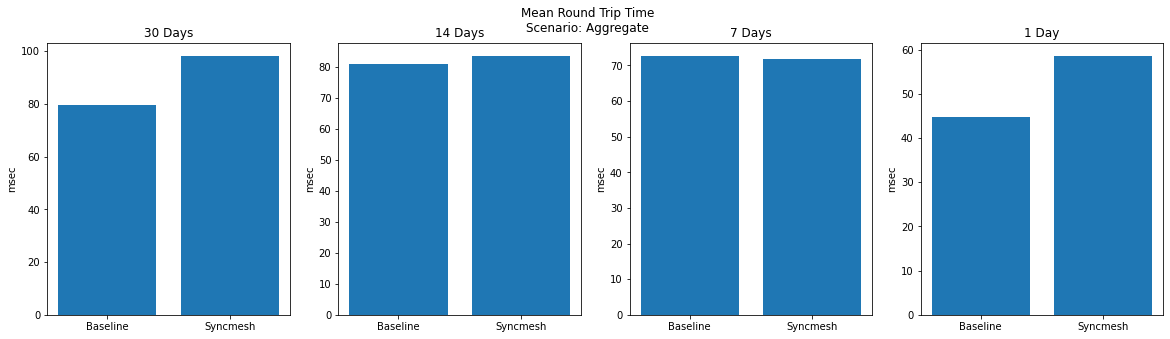

In [33]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,5))
cases = ['Baseline', 'Syncmesh']
values1 = [experiments[4]["baseAggregateRTT"], experiments[4]["syncAggregateRTT"]]
values2 = [experiments[5]["baseAggregateRTT"], experiments[5]["syncAggregateRTT"]]
values3 = [experiments[6]["baseAggregateRTT"], experiments[6]["syncAggregateRTT"]]
values4 = [experiments[7]["baseAggregateRTT"], experiments[7]["syncAggregateRTT"]]
fig.suptitle('Mean Round Trip Time\nScenario: Aggregate')
ax1.bar(cases,values1)
ax1.set_title('30 Days')
ax1.set_ylabel("msec")
ax2.bar(cases,values2)
ax2.set_title('14 Days')
ax2.set_ylabel("msec")
ax3.bar(cases,values3)
ax3.set_title('7 Days')
ax3.set_ylabel("msec")
ax4.bar(cases,values4)
ax4.set_title('1 Day')
ax4.set_ylabel("msec")
# ax.set_ylabel("Bytes")
# ax.set_xlabel("Time")
fig.savefig("out/rtt_mean_comparison_aggregate.png")
plt.show()

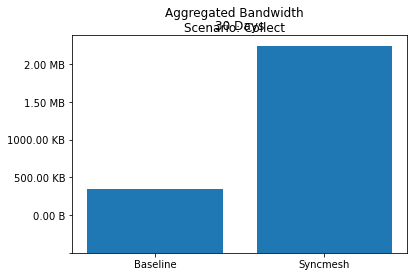

In [39]:
baseBytes = df_base["jsonPayload.bytes_sent"].sum()
syncBytes = df_sync["jsonPayload.bytes_sent"].sum()

fig, (ax1) = plt.subplots(1,1)
cases = ['Baseline', 'Syncmesh']
values1 = [baseBytes, syncBytes]
fig.suptitle('Aggregated Bandwidth\nScenario: Collect')
ax1.bar(cases,values1)
ax1.set_title('30 Days')
ax1.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
box = ax1.get_position()
# ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax.set_xlabel("Time")
fig.savefig("out/overall_bandwidth.png")
plt.show()